# load datasets and Pre Processing 

In [1]:
from torchvision.transforms import ToTensor, Resize
import torch
import torch.nn as nn
# import torchtext
from torchvision.transforms import ToTensor, Resize, Compose
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import PIL 
import os
import pandas as pd
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import glob
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [ ]:
! git clone https://github.com/amnghd/Persian_poems_corpus.git

## Pre-Processing

In [4]:
all_poems_path = glob.glob("Persian_poems_corpus/normalized/*.txt")
pathes = random.sample(all_poems_path, k=10)
poet_name = [name.split("/")[-1].split("_")[0] for name in pathes]
print("10 random poet names :", poet_name)

10 random poet names : ['amir', 'shahriar', 'khayyam', 'ferdousi', 'naserkhosro', 'bidel', 'hatef', 'vahshi', 'helali', 'hafez']


In [5]:
import csv
char_remov = ['\n', '\t']
with open('poems.csv', 'w', encoding='utf-8') as data:
    w = csv.writer(data)
    for path in pathes:
        with open(path, 'r') as poem:
            for sen in poem.readlines():
                for char in char_remov:
                    sen = sen.replace(char, '')
                if sen != '':
                    w.writerow([sen, pathes.index(path)])

In [6]:
df = pd.read_csv('poems.csv', encoding='utf-8').dropna()
df.columns = ['text' , 'label']
df

,text,label
0,با نصرت و فتح و ظفر و دولت والا,0
1,بنگر علم شاه جهان بر سر بالا,0
2,لشکر شده آسوده و ترمذ شده ایمن,0
3,نصرت شده پیوسته و دولت شده والا,0
4,فتح آمده و تهنیت آورده جهان را,0
...,...,...
269760,در پای خار هجران افتاده در کشاکش,9
269761,وز گلبن وصالت هرگز گلی نچیده,9
269762,گر دست من نگیری با خواجه بازگویم,9
269763,کز عاشقان بیدل دل می برد دو دیده,9


In [7]:
train, test = train_test_split(df, train_size=0.8)

In [10]:
from transformers import AutoConfig, AutoTokenizer, BertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenize_train = tokenizer(train['text'].tolist(), truncation=True, padding=True, max_length=256)
tokenize_test = tokenizer(test['text'].tolist(), truncation=True, padding=True, max_length=256)

# Part 1: train FC of model

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [12]:
import torch 
from torch.utils.data import Dataset
from transformers import AutoModel
from torch.utils.data import Dataset, DataLoader, random_split


class PoemDataset(Dataset):
    def __init__(self, encode, label):
        self.encode = encode
        self.label = label

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encode['input_ids'][idx])
        token_type_ids = torch.tensor(self.encode['token_type_ids'][idx])
        attention_mask = torch.tensor(self.encode['attention_mask'][idx])
        label = torch.tensor(self.label[idx])
        # item = { k : torch.tensor(v[idx]) for k, v in self.encode.items() }
        # item['label'] = torch.tensor(self.label[idx])
        return input_ids,token_type_ids,attention_mask,label

    def __len__(self):
        return len(self.label)

class PoemNetwork(nn.Module):
  def __init__(self):
    super(PoemNetwork, self).__init__()
    self.bert = AutoModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
    self.fc = nn.Linear(768, 32)
    self.fc2 = nn.Linear(32, 10)
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, input_ids, attention_mask):
    bert_model = self.bert(input_ids, attention_mask=attention_mask)[1]
    y = self.fc(bert_model)
    y1 = self.fc2(y)
    softMax = self.softmax(y1)

    return softMax

In [13]:
training_dataset = PoemDataset(tokenize_train, train['label'].tolist())
test_dataset = PoemDataset(tokenize_test, test['label'].tolist())

In [14]:
batchSize = 128

train_dataloader = DataLoader(training_dataset, batch_size=batchSize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchSize, shuffle=True)

In [15]:
model = PoemNetwork()
model.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PoemNetwork(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [55]:
for param in model.bert.parameters():
    param.requires_grad = False

In [ ]:
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [19]:
from tqdm import tqdm
def train_loop(epoch, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avgLoss = 0
    avgCorrect = 0
    model.train()
    with tqdm(dataloader, unit="batch") as tepoch:
        for  (X, token, mask, label) in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            
            # Compute prediction and loss
            size_batch = X.shape[0]

            X = X.to(device)
            mask = mask.to(device)
            label = label.to(device)
            pred = model(X, attention_mask=mask)

            loss = loss_fn(pred, label)
            avgLoss += loss.item()
            correct = (pred.argmax(1) == label).type(torch.float).sum().item()
            avgCorrect += correct
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            correct = correct / size_batch
            
            tepoch.set_postfix(batch_loss=loss.item(), batch_accuracy=100. * correct)
            
    avgLoss /= size
    avgCorrect /= size
    print(f" -Training Accuracy (Avg) = {(100*avgCorrect):>0.1f}%, Avg loss = {avgLoss:>8f} \n")
    return avgCorrect, avgLoss

def test_loop(dataloader, model, loss_fn, error):
    size = len(dataloader.dataset)
    avgLoss = 0
    avgCorrect = 0
    model.eval()
    with torch.no_grad():
        for  (X, token, mask, label) in dataloader:
            # Compute prediction and loss
            X = X.to(device)
            mask = mask.to(device)
            label = label.to(device)
            pred = model(input_ids=X, attention_mask=mask)

            avgLoss += loss_fn(pred, label).item()
            avgCorrect += (pred.argmax(1) == label).type(torch.float).sum().item()

    avgLoss /= size
    avgCorrect /= size
    print(f" -{error} : Accuracy = {(100*avgCorrect):>0.1f}%, Avg loss = {avgLoss:>8f} \n")
    return avgCorrect, avgLoss

In [59]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(log_dir='MLP_Board')

epochs = 5
for e in range(epochs):
    print(f" Epoch {e+1} -------------------------------")
    trainAcc, trainLoss = train_loop(e, train_dataloader, model, loss_fn, optimizer)
    # writer.add_scalar('Accuracy/train', trainAcc, e)
    # writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(test_dataloader, model, loss_fn, 'Test')
    # writer.add_scalar('Accuracy/validation', valAcc, e)
    # writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

 Epoch 1 -------------------------------


Epoch 1: 100%|██████████| 1004/1004 [00:40<00:00, 24.80batch/s, batch_accuracy=68.8, batch_loss=1.85]


 -Training Accuracy (Avg) = 29.9%, Avg loss = 0.016843 

 -Test : Accuracy = 31.0%, Avg loss = 0.016711 

 Epoch 2 -------------------------------


Epoch 2: 100%|██████████| 1004/1004 [00:40<00:00, 24.66batch/s, batch_accuracy=37.5, batch_loss=2.11]


 -Training Accuracy (Avg) = 33.1%, Avg loss = 0.016591 

 -Test : Accuracy = 35.0%, Avg loss = 0.016444 

 Epoch 3 -------------------------------


Epoch 3: 100%|██████████| 1004/1004 [00:40<00:00, 24.62batch/s, batch_accuracy=50, batch_loss=2]     


 -Training Accuracy (Avg) = 34.2%, Avg loss = 0.016503 

 -Test : Accuracy = 35.4%, Avg loss = 0.016424 

 Epoch 4 -------------------------------


Epoch 4: 100%|██████████| 1004/1004 [00:40<00:00, 24.52batch/s, batch_accuracy=43.8, batch_loss=2.06]


 -Training Accuracy (Avg) = 34.7%, Avg loss = 0.016469 

 -Test : Accuracy = 36.4%, Avg loss = 0.016351 

 Epoch 5 -------------------------------


Epoch 5: 100%|██████████| 1004/1004 [00:41<00:00, 24.47batch/s, batch_accuracy=31.2, batch_loss=2.14]


 -Training Accuracy (Avg) = 35.4%, Avg loss = 0.016415 

 -Test : Accuracy = 37.3%, Avg loss = 0.016275 

Done!


In [60]:
y_pred = []
y_true = []

with torch.no_grad():
    for  (X, token, mask, label) in test_dataloader:
        X = X.to(device)
        mask = mask.to(device)
        label = label.to(device)
        pred = model(input_ids=X, attention_mask=mask)
        output = pred.argmax(1).cpu().numpy()
        y_pred.extend(output)
        label = label.cpu().numpy()
        y_true.extend(label)

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [62]:
print(classification_report(y_true=y_true,
                            y_pred=y_pred,
                            target_names=poet_name))

              precision    recall  f1-score   support

       zahir       0.00      0.00      0.00      1468
        orfi       0.00      0.00      0.00      1553
      nezari       0.30      0.32      0.31      4045
        amir       0.41      0.65      0.51      7307
    shahriar       0.00      0.00      0.00       792
       iqbal       0.35      0.18      0.24      3228
  shabestari       0.00      0.00      0.00       689
      ghaani       0.36      0.54      0.43      8077
 manoochehri       0.00      0.00      0.00      1036
        feyz       0.37      0.26      0.31      3906

    accuracy                           0.37     32101
   macro avg       0.18      0.19      0.18     32101
weighted avg       0.30      0.37      0.32     32101



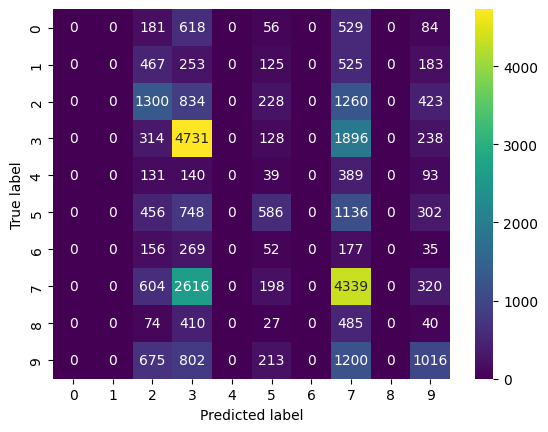

In [63]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Part 2 : Fine-tune Model

### Adam optimizer :

In [21]:
model_fineTuned_adam = PoemNetwork()
model_fineTuned_adam.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PoemNetwork(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [22]:
for param in model_fineTuned_adam.bert.parameters():
    param.requires_grad = True

In [24]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(log_dir='MLP_Board')

learning_rate = 2e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_fineTuned_adam.parameters(), lr=learning_rate)

epochs = 5
for e in range(epochs):
    print(f" Epoch {e+1} -------------------------------")
    trainAcc, trainLoss = train_loop(e, train_dataloader, model_fineTuned_adam, loss_fn, optimizer)
    # writer.add_scalar('Accuracy/train', trainAcc, e)
    # writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(test_dataloader, model_fineTuned_adam, loss_fn, 'Test')
    # writer.add_scalar('Accuracy/validation', valAcc, e)
    # writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

 Epoch 1 -------------------------------


Epoch 1: 100%|██████████| 1687/1687 [03:38<00:00,  7.73batch/s, batch_accuracy=100, batch_loss=1.46] 


 -Training Accuracy (Avg) = 66.4%, Avg loss = 0.014077 

 -Test : Accuracy = 70.1%, Avg loss = 0.013760 

 Epoch 2 -------------------------------


Epoch 2: 100%|██████████| 1687/1687 [03:39<00:00,  7.67batch/s, batch_accuracy=50, batch_loss=1.96]  


 -Training Accuracy (Avg) = 70.7%, Avg loss = 0.013707 

 -Test : Accuracy = 72.2%, Avg loss = 0.013594 

 Epoch 3 -------------------------------


Epoch 3:  78%|███████▊  | 1320/1687 [02:52<00:47,  7.65batch/s, batch_accuracy=73.4, batch_loss=1.73]


KeyboardInterrupt: 

In [25]:
y_pred = []
y_true = []

with torch.no_grad():
    for  (X, token, mask, label) in test_dataloader:
        X = X.to(device)
        mask = mask.to(device)
        label = label.to(device)
        pred = model_fineTuned_adam(input_ids=X, attention_mask=mask)
        output = pred.argmax(1).cpu().numpy()
        y_pred.extend(output)
        label = label.cpu().numpy()
        y_true.extend(label)

In [26]:
print(classification_report(y_true=y_true,
                            y_pred=y_pred,
                            target_names=poet_name))

              precision    recall  f1-score   support

        amir       0.58      0.83      0.69      7411
    shahriar       0.00      0.00      0.00       733
     khayyam       0.00      0.00      0.00       249
    ferdousi       0.85      0.98      0.91     19769
 naserkhosro       0.00      0.00      0.00      4268
       bidel       0.77      0.95      0.85     13092
       hatef       0.00      0.00      0.00       652
      vahshi       0.35      0.37      0.36      4314
      helali       0.00      0.00      0.00      1662
       hafez       0.00      0.00      0.00      1803

    accuracy                           0.73     53953
   macro avg       0.26      0.31      0.28     53953
weighted avg       0.61      0.73      0.66     53953



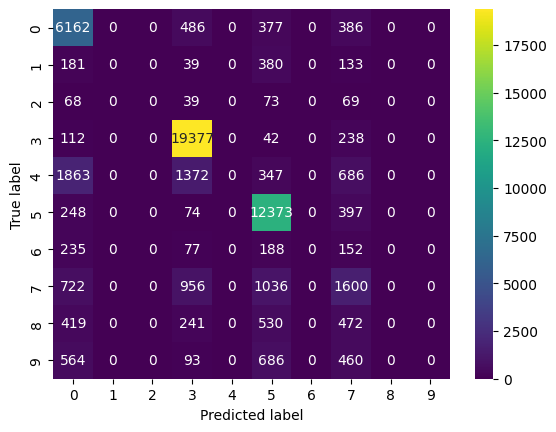

In [27]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### SGD Optimizer:

In [ ]:
model_fineTuned_sgd = PoemNetwork()
model_fineTuned_sgd.to(device)

In [ ]:
for param in model_fineTuned_sgd.bert.parameters():
    param.requires_grad = True

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(log_dir='MLP_Board')

learning_rate = 2e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_fineTuned_sgd.parameters(), lr=learning_rate)

epochs = 5
for e in range(epochs):
    print(f" Epoch {e+1} -------------------------------")
    trainAcc, trainLoss = train_loop(e, train_dataloader, model_fineTuned_sgd, loss_fn, optimizer)
    # writer.add_scalar('Accuracy/train', trainAcc, e)
    # writer.add_scalar('Loss/train', trainLoss, e)

    valAcc, valLoss = test_loop(test_dataloader, model_fineTuned_sgd, loss_fn, 'Test')
    # writer.add_scalar('Accuracy/validation', valAcc, e)
    # writer.add_scalar('Loss/validation', valLoss, e)
    
print("Done!")

In [ ]:
y_pred = []
y_true = []

with torch.no_grad():
    for  (X, token, mask, label) in test_dataloader:
        X = X.to(device)
        mask = mask.to(device)
        label = label.to(device)
        pred = model_fineTuned_sgd(input_ids=X, attention_mask=mask)
        output = pred.argmax(1).cpu().numpy()
        y_pred.extend(output)
        label = label.cpu().numpy()
        y_true.extend(label)

In [ ]:
print(classification_report(y_true=y_true,
                            y_pred=y_pred,
                            target_names=poet_name))

In [ ]:
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

sb.heatmap(cf_matrix,
           annot=True,
           fmt='d',
           cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Part 3 : Perplexity

In [75]:
dfSample = df.sample(1000)
tokenize_sample = tokenizer(dfSample['text'].tolist(), truncation=True, padding=True, max_length=256)
sample_dataset = PoemDataset(tokenize_sample, dfSample['label'].tolist())

sample_dataloader = DataLoader(sample_dataset, batch_size=64, shuffle=True)

In [77]:
loss_fn = nn.CrossEntropyLoss()
def metrics(dataloader, model, loss_fn):
    y_pred = []
    y_true = []
    loss = 0
    with torch.no_grad():
        for  (X, token, mask, label) in sample_dataloader:
            X = X.to(device)
            mask = mask.to(device)
            label = label.to(device)
            pred = model(input_ids=X, attention_mask=mask)

            loss += loss_fn(pred, label).item() * (X.size(0)/X.size(1))

            output = pred.argmax(1).cpu().numpy()
            y_pred.extend(output)
            label = label.cpu().numpy()
            y_true.extend(label)
            
    return y_true, y_pred, loss

In [78]:
true_fix, pred_fix, loss = metrics(sample_dataloader, model, loss_fn)
print("Perplexity : ", np.exp(loss/len(sample_dataloader)))

Perplexity :  4819.2646988088645


In [79]:
true_fix, pred_fix, loss = metrics(sample_dataloader, model_fineTuned_adam, loss_fn)
print("Perplexity : ", np.exp(loss/len(sample_dataloader)))

Perplexity :  548.301688739443


In [ ]:
true_fix, pred_fix = metrics(sample_dataloader, model)

> Perplexity is usually used only to determine how well a model has learned the training set. as you can see, model that fine tuned worked better beacuase the perplexity is much lower than another model(without fine tuned)

# transformer 

In [8]:
id2label = { poet_name.index(i):i for i in poet_name}
label2id = { i:poet_name.index(i) for i in poet_name}

In [9]:
from transformers import AutoConfig, AutoTokenizer, BertForSequenceClassification
from datasets import load_metric

config = AutoConfig.from_pretrained("HooshvareLab/bert-fa-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained("HooshvareLab/bert-fa-base-uncased" , num_labels = 10, id2label=id2label, label2id=label2id)

2023-02-01 23:38:38.324387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-01 23:38:38.324413: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architec

In [10]:
from datasets import load_dataset
train.to_csv('train.csv', index=False, encoding='utf-8')
test.to_csv('test.csv', index=False, encoding='utf-8')

data_files = {"train" : "train.csv",
              "test" : "test.csv"}
dataset = load_dataset("csv", data_files=data_files )
dataset

Using custom data configuration default-bf64181d8af69a3b


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/user01/.cache/huggingface/datasets/csv/default-bf64181d8af69a3b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 153835
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 38459
    })
})

In [11]:
tokenize_dataset = dataset.map(lambda data: tokenizer(data['text'], truncation=True, padding="max_length"), batched=True)

  0%|          | 0/154 [00:00<?, ?ba/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/39 [00:00<?, ?ba/s]

In [12]:
tokenize_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 153835
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 38459
    })
})

## Adam

In [13]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
metric = load_metric("accuracy")

training_args = TrainingArguments(
    output_dir="train_poem_arg",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    num_train_epochs = 3,
    learning_rate=2e-4,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    # optim = 'adam',
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
)    

In [14]:
import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [15]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=tokenize_dataset["train"],
    eval_dataset=tokenize_dataset["test"],
    compute_metrics=compute_metrics
)

In [16]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 153835
  Num Epochs = 3
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 3606
  Number of trainable parameters = 162849034


  0%|          | 0/3606 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
#TODO error
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 52283
  Batch size = 128


{'eval_loss': 0.7814357280731201,
 'eval_accuracy': 0.7465141633035595,
 'eval_runtime': 12.49,
 'eval_samples_per_second': 4186.005,
 'eval_steps_per_second': 32.746,
 'epoch': 3.0}

In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification", model=bert_model.cpu(), tokenizer=tokenizer)

In [ ]:
label2id[classifier(['به نام خداوند جان و خداوند نام'])[0]['label']]

8

In [ ]:
y_pred = []
y_true = []
test_np = np.array(test)

for text,label in tqdm(test_np):
    y_pred.append(label2id[classifier([text])[0]['label']])
    y_true.append(label)

 18%|█▊        | 9304/52283 [03:26<15:54, 45.01it/s]  


KeyboardInterrupt: 

In [ ]:
import pycm
cm = pycm.ConfusionMatrix(actual_vector=truth, predict_vector=prediction)
cm.stat(summary=True)
cm.plot()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# classification report
print(classification_report(y_true=y_true, 
                            y_pred=y_pred,
                            target_names=['Boot','Sandal','Shoe']))

In [ ]:
# Creating confusion matrix
## true elements for each class : diagonal elements of matrix in class's row 
## false elements for each classs : others 
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
print(conf_mat)

In [ ]:
seaborn.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['Boot','Sandal','Shoe'], yticklabels=['Boot','Sandal','Shoe'], cmap='viridis')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()